# Loading Packages

In [1]:
import re 
import warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence, unpack_sequence, PackedSequence, pad_sequence
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import d2l
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat
from torch.optim.lr_scheduler import ReduceLROnPlateau
import datetime
import h5py
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import importlib
from scipy import stats

# Functions

In [2]:
def elu1(x):
    return F.elu(x, inplace=True) + 1.

class Elu1(nn.Module):
    """
    Elu activation function shifted by 1 to ensure that the
    output stays positive. That is:

    Elu1(x) = Elu(x) + 1
    """

    def forward(self, x):
        return elu1(x)

In [3]:
class LinearReadout(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
        
    def forward(self, x):
        x = self.linear(x)
        return x.squeeze(dim=2)

In [4]:
class NonlinearDecoder(nn.Module):
    def __init__(self, hidden_size=32, output_size=192, dropout=0.0, device=None):
        super().__init__()
        
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.device = device
        
    def forward(self, factors):
        # concatenate all sequences, forward into linear layer and split again
        lengths = [factor.shape[0] for factor in factors]
        cat_fs = torch.cat(factors, dim=0)
      #  cat_fs = self.dropout(cat_fs)
        rates = self.linear(cat_fs)
        rates = [rate for rate in torch.split(rates, lengths)]
        
        return rates
    
    
class LinearReadout(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.linear(x)
        #return x.squeeze(dim=2)
        return x

In [5]:
class CoreAndReadout(nn.Module):
    def __init__(self, core, readout, nonlinearity=None):
        super().__init__()
        self.core = core
        self.readout = readout
        self.nonlinearity = elu1 if nonlinearity is None else nonlinearity
        
    def forward(self, x):
        x = self.core(x)
        x = self.readout(x)
        return x

In [6]:
def get_device(cpu_preference=False, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() and not cpu_preference else "cpu")
    if verbose: print("Using device:", device)
    return device

In [7]:
def create_lineplots(all_probs_array, y_val, y_labels, trial, shift, n_epochs, hidden_size, file_path, features, size=(18, 5), show_plot=True):
    # Create a figure with subplots for each variable
    fig, axs = plt.subplots(len(y_labels), 1, figsize=size, linewidth=0.01)
    
    if len(y_labels) == 1:
        axs = [axs]  # Wrap the single Axes object in a list   
    
    for i, label in enumerate(y_labels):
        ax = axs[i]
        ax.plot(y_val[:, i], label='True', linewidth=2.5, color='blue')  # True values in blue
        ax.plot(all_probs_array[:, i], label='Predicted', linewidth=2.5, color='orange')  # Predicted values in orange

        # Set titles and labels
        if i == 0:  # Only set title for the first plot
            ax.set_title(f'(dyadic model) (val trial: {trial}, lag: {shift}, epochs: {n_epochs}, hidden states: {hidden_size})')
            ax.legend()
        
        ax.set_xlabel('Time Step',labelpad=0.5)
        ax.set_ylabel(label)
        feature_names = ", ".join(features)
        fig.text(.5, .00001, f"Features: {feature_names}", ha='center', fontsize=14)
        
        if file_path is not None:
            plt.savefig(file_path)

    # Show the plots if requested
    if show_plot:
        plt.tight_layout()  # Adjust spacing between subplots for better layout
        plt.show()

In [8]:
class M2S_Loss2(nn.Module):
    def __init__(self, criterion=None):
        super().__init__()
        self.criterion = criterion if criterion is not None else nn.MSELoss(reduction='sum')
        
    def forward(self, y_pred, y):
        # Ensure y_pred and y are lists of sequences
        if isinstance(y_pred, list) and isinstance(y, list):
            # Pad sequences to ensure they have the same length
            padded_y_pred = pad_sequence([seq for seq in y_pred], batch_first=True)
            padded_y = pad_sequence([seq for seq in y], batch_first=True)
            
            # Move to the same device
            device = padded_y_pred.device
            padded_y = padded_y.to(device)
            
            # Create a mask to ignore padding tokens
            mask = (padded_y != 0).float()
            
            # Compute the loss (MSE in this case) between the padded sequences
            loss = self.criterion(padded_y_pred * mask, padded_y * mask)
            return loss
        else:
            raise ValueError('y_pred and y should be lists of sequences.')

In [9]:
class M2S_Loss3(nn.Module):
    def __init__(self, criterion=None):
        super().__init__()
        # Default criterion is MSELoss with mean reduction
        self.criterion = criterion if criterion is not None else nn.MSELoss(reduction='mean')
        
    def forward(self, y_pred, y):
        # Ensure y_pred and y are lists of sequences
        if isinstance(y_pred, list) and isinstance(y, list):
            total_loss = 0
            total_valid_sequences = 0
            
            for i in range(len(y_pred)):
                pred_seq = y_pred[i]
                target_seq = y[i]

                # Ensure both sequences have the same length
                valid_length = min(pred_seq.shape[0], target_seq.shape[0])

                # Slice sequences to valid lengths (no padding assumed here)
                pred_seq = pred_seq[:valid_length]
                target_seq = target_seq[:valid_length]
                
                # Calculate the loss for this sequence pair
                loss = self.criterion(pred_seq, target_seq)
                
                total_loss += loss
                total_valid_sequences += 1
            
            # Return the mean loss across all valid sequences
            return total_loss / total_valid_sequences
        else:
            raise ValueError('y_pred and y should be lists of sequences.')

In [10]:
def train(dataloader, model, optimizer, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.train()
    for x, y in dataloader:

        optimizer.zero_grad()
        
        y_pred = model(x)
        
        
        loss = loss_fn(y_pred, y)
        epoch_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    return np.mean(epoch_loss), y_pred

In [11]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss.append(loss.item())
    
    return np.mean(epoch_loss), y_pred

In [12]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, verbose=True):
    train_losses = []
    val_losses = []
    yPred_tr, yPred_val = [], []    
    
    for epoch in range(num_epochs):
        epoch_train_loss, yPred_tr = train(train_dataloader, model, optimizer, loss_fn, device)
        
        epoch_val_loss, yPred_val = validate(val_dataloader, model, loss_fn, device)
        
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        train_losses.append(epoch_train_loss)
        
        val_losses.append(epoch_val_loss)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, val loss: {epoch_val_loss}")
            
    return train_losses, val_losses, yPred_tr, yPred_val

In [13]:
def collate_packed_sequences(batch):
    X, Y = zip(*batch)
    X = [torch.Tensor(elem).to(device) for elem in X]
    Y = [torch.Tensor(elem).to(device) for elem in Y]
    return pack_sequence(X, enforce_sorted=False), Y

In [14]:
class TrialDataset_seq(Dataset):
    def __init__(self, df, X, y, seq_len=1):
        self.df = df
        self.X = X
        self.y = y
        self.bin_size = seq_len
        self.trials = df['trial'].unique()  # Unique trial identifiers
    
    def __len__(self):
        return len(self.trials)  # Number of trials
    
    def __getitem__(self, idx):
        # Get all rows for a specific trial
        trial_number = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial_number]
        
        # Compute the moving average for the features
        features = trial_data[self.X].rolling(window=self.bin_size).mean().dropna().values
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # Compute the moving average for the labels (if needed)
        labels = trial_data[self.y].rolling(window=self.bin_size).mean().dropna().values
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        
        return features_tensor, labels_tensor

In [15]:
class GRUDecoder(nn.Module):
    def __init__(self, hidden_size=32, output_size=192, num_layers=1, dropout=0.0, device=None):
        super().__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.device = device

        # Define the GRU layer
        self.gru = nn.GRU(input_size=hidden_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=True, 
                          dropout=dropout)

        # Output linear layer to transform GRU outputs to desired output size
        self.fc = nn.Linear(hidden_size, output_size)

        # Optional dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, factors):
        # Ensure the input is a list of sequences (tensors)
        if not isinstance(factors, list):
            raise ValueError("Expected input to be a list of sequences.")

        # Get the lengths of each sequence
        lengths = [factor.shape[0] for factor in factors]

        # Concatenate all sequences into a single tensor along the batch dimension
        # The batch size will be the total number of sequences, each with its own sequence length
        cat_fs = torch.cat(factors, dim=0).unsqueeze(1)  # Add batch dimension (for GRU)

        # Pass the concatenated sequence through the GRU
        gru_output, _ = self.gru(cat_fs)
        gru_output = self.dropout(gru_output)
        # Apply the linear transformation (fc) to the GRU output
        rates = self.fc(gru_output)

        # Remove the batch dimension and split the result back into the original list of sequences
        rates = rates.squeeze(1)  # Remove the added batch dimension

        # Split back into the original sequences based on the lengths
        rates = list(torch.split(rates, lengths))  # Convert tuple to list here

        # Return the list of output sequences
        return rates

In [16]:
class ExperimentEncoder(nn.Module):
    def __init__(self, input_size=12, hidden_size=32, num_layers=1, device=None):
        super().__init__()
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bias=False)
        self.initial_hidden_state = nn.Parameter(torch.zeros(1, 1, hidden_size))  # unidirectional GRU
        self.device = device
        
    def forward(self, input_):
        # Input should be a PackedSequence
        if not isinstance(input_, PackedSequence):
            raise ValueError('Input must be a PackedSequence.')
        
        batch_size = input_.unsorted_indices.shape[0]  # Extract batch size from PackedSequence
        initial_hidden_state = self.initial_hidden_state.repeat(1, batch_size, 1)
        
        # Forward pass through GRU
        factors, _ = self.gru(input_, initial_hidden_state)
        
        # Return unpacked sequence
        factors = unpack_sequence(factors)
        
        return factors

In [17]:
class ExperimentEncoder_LN(nn.Module):
    def __init__(self, input_size=12, hidden_size=32, num_layers=1, device=None):
        super().__init__()
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bias=False)
        
        # Initialize the hidden state for GRU
        self.initial_hidden_state = nn.Parameter(torch.zeros(1, 1, hidden_size))  # unidirectional GRU
        
        # Add layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.device = device
        
    def forward(self, input_):
        # Input should be a PackedSequence
        if not isinstance(input_, PackedSequence):
            raise ValueError('Input must be a PackedSequence.')
        
        batch_size = input_.unsorted_indices.shape[0]  # Extract batch size from PackedSequence
        initial_hidden_state = self.initial_hidden_state.repeat(1, batch_size, 1)
        
        # Forward pass through GRU
        factors, _ = self.gru(input_, initial_hidden_state)
        
        # Return unpacked sequence
        factors = unpack_sequence(factors)
        factors[0] = self.layer_norm(factors[0])
        
        return factors

In [18]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            verbose (bool): If True, prints messages about early stopping progress.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()  # Save the initial model state
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()  # Update the best model state
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_model(self, model):
        """
        Restores the model state to the best state observed during training.
        """
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
        return model


def run_training_ES(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, verbose=False, patience=20):
    train_losses = []
    val_losses = []
    yPred_tr, yPred_val = [], []    

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    for epoch in range(num_epochs):
        epoch_train_loss, yPred_tr = train(train_dataloader, model, optimizer, loss_fn, device)
        
        epoch_val_loss, yPred_val = validate(val_dataloader, model, loss_fn, device)
        
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Early stopping check
        early_stopping(epoch_val_loss, model)

        # Print training information
        if epoch % 50 == 0 or verbose:
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, val loss: {epoch_val_loss}")
        
        # Break training if early stopping criteria are met
        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring the best model state...")
            model = early_stopping.restore_best_model(model)
            break

    # Return the best model state and the training history
    model = early_stopping.restore_best_model(model)
    return train_losses, val_losses, yPred_tr, yPred_val

In [19]:
def run_training_ES_C(
    train_dataloader, 
    val_dataloader, 
    model, 
    optimizer, 
    loss_fn, 
    num_epochs, 
    scheduler=None, 
    device=None, 
    verbose=False, 
    patience=20, 
    save_dir=".", 
    model_name="model"
    ):
    train_losses = []
    val_losses = []
    yPred_tr, yPred_val = [], []    

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    for epoch in range(num_epochs):
        # Training step
        epoch_train_loss, yPred_tr = train(train_dataloader, model, optimizer, loss_fn, device)
        
        # Validation step
        epoch_val_loss, yPred_val = validate(val_dataloader, model, loss_fn, device)
        
        # Scheduler step
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        # Log the losses
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Early stopping check
        early_stopping(epoch_val_loss, model)

        # Save model every 200 epochs
        #if epoch % 200 == 0 and epoch != 0:
           # checkpoint_path = f'{save_dir}/{model_name}_epoch_{epoch}_checkpoint.pth'
            #torch.save(model.state_dict(), checkpoint_path)
            #print(f"Model checkpoint saved at epoch {epoch}: {checkpoint_path}")

        # Print training information
        if verbose or epoch % 200 == 0 and epoch != 0:
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, val loss: {epoch_val_loss}")
        
        # Break training if early stopping criteria are met
        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring the best model state...")
            model = early_stopping.restore_best_model(model)
            break

    # Final restoration of the best model
    model = early_stopping.restore_best_model(model)


    # Save the final best model after all epochs
    best_model_path = f'{save_dir}/{model_name}_best_model.pth'
    torch.save(model.state_dict(), best_model_path)
    print(f"Final best model saved: {best_model_path}")
    return train_losses, val_losses, yPred_tr, yPred_val


In [20]:
device = get_device()

Using device: cpu


In [21]:
def create_lineplots(all_probs_array, y_val, y_labels, trial, shift, n_epochs, hidden_size, file_path, features, size=(18, 5), show_plot=True):
    # Create a figure with subplots for each variable
    fig, axs = plt.subplots(len(y_labels), 1, figsize=size, linewidth=0.01)
    
    if len(y_labels) == 1:
        axs = [axs]  # Wrap the single Axes object in a list   
    
    for i, label in enumerate(y_labels):
        ax = axs[i]
        ax.plot(y_val[:, i], label='True', linewidth=2.5, color='blue')  # True values in blue
        ax.plot(all_probs_array[:, i], label='Predicted', linewidth=2.5, color='orange')  # Predicted values in orange

        # Set titles and labels
        if i == 0:  # Only set title for the first plot
            ax.set_title(f'(dyadic model) (val trial: {trial}, lag: {shift}, epochs: {n_epochs}, hidden states: {hidden_size})')
            ax.legend()
        
        ax.set_xlabel('Time Step',labelpad=0.5)
        ax.set_ylabel(label)
        feature_names = ", ".join(features)
        fig.text(.5, .00001, f"Features: {feature_names}", ha='center', fontsize=14)
        
        if file_path is not None:
            plt.savefig(file_path)

    # Show the plots if requested
    if show_plot:
        plt.tight_layout()  # Adjust spacing between subplots for better layout
        plt.show()

In [22]:
def bin_trial_data(trial_df):
    return trial_df.groupby(trial_df.index // 5).mean()

# Training loop

In [ ]:
# Define the range of all trials and the list of trials to drop
all_trials = np.arange(1, 62)  # Numbers from 1 to 61
drop_trials = [4, 7, 21, 46, 47, 48, 54, 58, 17, 8, 52, 56, 17]

# Remove drop_trials from all_trials
available_trials = np.setdiff1d(all_trials, drop_trials)
folds = np.array_split(available_trials, 10)
# Set a random seed for reproducibility
np.random.seed(100)  # You can change 42 to any integer you like

# Shuffle the array randomly
np.random.shuffle(available_trials)
folds = [list(fold) for fold in np.array_split(available_trials, 10)]

In [ ]:
for f in folds:
    set_value = f
    print(set_value)

In [ ]:
 # Layer Norm and scheduler 
import os
from time import perf_counter, sleep

import os
from time import perf_counter, sleep

lag_values = np.arange(7,25)
folds = [[1,16,25,30,37]]
drop_trials = [4,7,21,46,47,48,54,58,17,8,52,56,17]
test_trials = []
models = ['solo','dyadic']
start = perf_counter()
# Some Code
for m in models:
    for s in lag_values:
            for f in folds:
                
                model_type = m
                save_dir = f'/kaggle/working/{model_type}_1var'
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                set_value = f
                hidden_size= 16
                n_epochs = 2000
        
                shift = s
                model_name = str(model_type)+'_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v'+str(set_value)+'_s'+str(shift)
                labels = ['aDistReach_3']
                if model_type == 'dyadic':
                    columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4','oDistReach_1','oDistReach_2','oDistReach_3','oDistReach_4']
                else:
                    columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
        
        
                lag_word = '_lagged'
                input_size = len(columns_to_shift)
                output_size = len(labels)
        
                core = ExperimentEncoder_LN(input_size,hidden_size, num_layers=1)
                readout = NonlinearDecoder(hidden_size, output_size)
                model = CoreAndReadout(core, readout)
                model = model.to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
                loss = nn.MSELoss() 
                loss_fn = M2S_Loss3(loss)
                data = '/kaggle/input/dataset-v2/combined_dataset.csv'
        
                df = pd.read_csv(data)
                
                df = df[~df['trial'].isin(drop_trials)]
        
                                                # Function to bin within each trial
        
        
                    # Apply binning within each 'trial' group
                df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
                df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                shifted_df = pd.DataFrame()
        
        
                # Loop through unique trial values
                for trial_value in df['trial'].unique():
                    # Filter the DataFrame for the current trial
                    trial_df = df[df['trial'] == trial_value].copy()
        
                    # Create shifted columns for each column in columns_to_shift
                    for col in columns_to_shift:
                        new_col_name = col + lag_word
                        trial_df[new_col_name] = trial_df[col].shift(-shift)
        
        
                    # Drop the last 'i' records for each trial
                    trial_df = trial_df.dropna()
        
        
        
                    # Append the modified trial_df to the shifted_df
                    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
               
                features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]
                
                batch_size = len(shifted_df['trial'].unique()) - len(set_value)
        
                train_set = shifted_df[~shifted_df['trial'].isin(set_value)]
                train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)
                train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_packed_sequences)
        
                val_set = shifted_df[shifted_df['trial'].isin(set_value)]
                val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
                val_dataloader = DataLoader(val_dataset, batch_size=len(set_value), shuffle=False, collate_fn=collate_packed_sequences)
        
        
                train_losses, val_losses, yPred_tr, yPred_val = train_losses, val_losses, yPred_tr, yPred_val = run_training_ES_C(train_dataloader, val_dataloader, model, optimizer, loss_fn, 
                                                                                    n_epochs, scheduler=None, device=device, verbose=False, patience=50, save_dir=save_dir,model_name=model_name)
                # Create a figure for the learning curve
                fig, ax = plt.subplots(figsize=(18,4))  # Adjust size if necessary
        
                # Plot both Train and Validation Loss on the same axis
                ax.plot((train_losses), label='Train Loss', color='blue')
                ax.plot((val_losses), label='Validation Loss', color='orange')
        
                # Set title, labels, and legend
                ax.set_title((f'Learning curve ({model_type} - packed): (val trial: {set_value}, lag {shift}, epochs: {n_epochs}, hidden states: {hidden_size})'))
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend(loc='upper right')
                ax.grid()
        
                # Save the learning curve plot
                plot_name = f'{model_type}_{set_value}_e{n_epochs}_h{hidden_size}_l{shift}_LC.png'
                lc_dir = os.path.join(save_dir, plot_name)
                plt.savefig(lc_dir)
                plt.show()
        
                # Set model to evaluation mode
                model.eval()
        
        
                # Loop through each batch in the validation dataloader
                with torch.no_grad():
                    for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                        # Move inputs and outputs to the appropriate device
                        inputs = inputs.to(device)
                        outputs = [output.to(device) for output in outputs]  # Ensure all outputs are on the same device
        
                        # Get model predictions for the current batch
                        y_pred_batch = model(inputs)  # Predictions for the entire batch
        
                        # Iterate through each trial in the batch
                        for i in np.arange(len(y_pred_batch)):
                            print(f'Trial: {set_value[i]}')
                            prediction = y_pred_batch[i]  # Get the prediction for the current trial
        
                            # Convert the prediction and true values to numpy for plotting
                            prediction_np = prediction.detach().cpu().numpy()  # Convert to numpy for plotting
                            true_value_np = outputs[i].detach().cpu().numpy()  # True values for the current trial
        
                            # Check the shapes for debugging
                            plot_filename = f'{model_type}_v{set_value[i]}_e{n_epochs}_h{hidden_size}_l{shift}.png'
                            plot_dir = os.path.join(save_dir, plot_filename)
        
        
                            # Call your plotting function to visualize predictions vs. true values
                            create_lineplots(
                                all_probs_array=np.exp(prediction_np),  # Full prediction for the current trial
                                y_val=np.exp(true_value_np),            # True value for the current trial
                                y_labels=labels,  # Adjust as needed
                                trial=set_value[i],             # Use the trial ID from set_value
                                shift=shift,                    # Set shift if applicable
                                n_epochs=n_epochs,              # Number of epochs used
                                hidden_size=hidden_size,        # Hidden size of the model
                                file_path=plot_dir,  # Modify path as needed
                                features=features,  # Feature names
                                size=(22, 4),                   # Figure size
                                show_plot=True,   # Set to True if you want to display plots during iteration
                                model_type=model_type
                            )



end = perf_counter()

print(f"Time taken to execute code : {end-start}")

# Evaluation and saving results

In [51]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

results_path = 'C:/Users/kacpe/Desktop/lab_rotation_git/results/results_batch5_1var.csv' # specify path to save results
data = "C:/Users/kacpe/Desktop/lab_rotation_git/datasets/combined_dataset.csv" 
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drop_trials = [4,7,21,46,47,48,54,58,17,8,52,56,17]
# Initialize a list to store all results
all_results = []
folds = [1,16,25,30,37]
models = ['solo','dyadic']
lag_values = np.arange(1,25)
for m in models:
    for s in lag_values:
        for f in folds:
            model_type = m
            set_value = [f]
        
            hidden_size = 16
            n_epochs = 2000
            shift = s
            model_name = f'{model_type}_h{hidden_size}_e{n_epochs}_v{folds}_s{shift}' # naming convention for models 
            model_path = f'C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/1111_fixedLog/5batch/{model_type}_1var/models/{model_name}_best_model.pth' # specify model path 
            labels = ['aDistReach_3']#['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4']  # ['aDistReach_3'] for model with 1 output 
            if model_type == 'dyadic':
                columns_to_shift = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'oDistReach_1', 'oDistReach_2', 'oDistReach_3', 'oDistReach_4']
            else:
                columns_to_shift = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4']

            lag_word = '_lagged'
            input_size = len(columns_to_shift)
            output_size = len(labels)

            core = ExperimentEncoder_LN(input_size, hidden_size, num_layers=1)
            readout = NonlinearDecoder(hidden_size, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            loss = nn.MSELoss()
            loss_fn = M2S_Loss3(loss)

            df = pd.read_csv(data)
            df = df[~df['trial'].isin(drop_trials)]

            # Function to bin within each trial
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                trial_df = df[df['trial'] == trial_value].copy()
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                trial_df = trial_df.dropna()
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

            features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]
            batch_size = len(shifted_df['trial'].unique()) - len(set_value)

            val_set = shifted_df[shifted_df['trial'].isin(set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            val_dataloader = DataLoader(val_dataset, batch_size=len(set_value), shuffle=False, collate_fn=collate_packed_sequences)

            model.load_state_dict(torch.load(model_path, map_location=device))

            # Evaluation
            model.eval()
            results = []

            with torch.no_grad():
                for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                    inputs = inputs.to(device)
                    outputs = [output.to(device) for output in outputs]
                    y_pred_batch = model(inputs)
                    
                    for i in range(len(y_pred_batch)):
                        prediction = y_pred_batch[i]
                        prediction_np = prediction.detach().cpu().numpy()
                        true_value_np = outputs[i].detach().cpu().numpy()
                        r2_h = r2_score(true_value_np, prediction_np)
                        mse_h = loss_fn(y_pred_batch, outputs)
                        
                        results.append({
                            'model_type': model_type,
                            'shift': shift,
                            'val': set_value[0],
                            'hidden_size': hidden_size,
                            'r2': r2_h,
                            'mse': mse_h.item()
                        })

            # Append the results for this model to the all_results list
            all_results.extend(results)

# Save all results to a single CSV file
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv(results_path, index=False)

print(f"Evaluation complete. All results saved to {results_path}")


Evaluation complete. All results saved to C:/Users/kacpe/Desktop/lab_rotation_git/results/results_batch5_1var.csv


In [64]:
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

results_path = 'C:/Users/kacpe/Desktop/lab_rotation_git/results/results_hidden_dyadic_4var.csv' # specify path to save results
predictions_dir = 'C:/Users/kacpe/Desktop/lab_rotation_git/results/predictions_hidden/' # specify directory to save predictions
data = "C:/Users/kacpe/Desktop/lab_rotation_git/datasets/combined_dataset.csv" 
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drop_trials = [4,7,21,46,47,48,54,58,17,8,52,56,17]
# Initialize a list to store all results
all_results = []
folds = [1,16,25,30,37]
models = ['solo','dyadic']
lag_values = np.arange(1,25,2)
hidden_values = [18,20,22,24]
# Create directory for predictions if it doesn't exist
os.makedirs(predictions_dir, exist_ok=True)

for h in hidden_values:
    for s in lag_values:
        for f in folds:
            model_type = 'dyadic'
            set_value = [f]
        
            hidden_size = h
            n_epochs = 2000
            shift = s
            model_name = f'{model_type}_h{hidden_size}_e{n_epochs}_v{folds}_s{shift}' # naming convention for models 
            model_path = f'C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/1911_diffHsize/dyadic_h{hidden_size}_4var/models/{model_name}_best_model.pth' # specify model path 
            labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4']  # ['aDistReach_3'] for model with 1 output 
            if model_type == 'dyadic':
                columns_to_shift = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'oDistReach_1', 'oDistReach_2', 'oDistReach_3', 'oDistReach_4']
            else:
                columns_to_shift = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4']

            lag_word = '_lagged'
            input_size = len(columns_to_shift)
            output_size = len(labels)

            core = ExperimentEncoder_LN(input_size, hidden_size, num_layers=1)
            readout = NonlinearDecoder(hidden_size, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            loss = nn.MSELoss()
            loss_fn = M2S_Loss3(loss)

            df = pd.read_csv(data)
            df = df[~df['trial'].isin(drop_trials)]

            # Function to bin within each trial
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                trial_df = df[df['trial'] == trial_value].copy()
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                trial_df = trial_df.dropna()
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

            features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]
            batch_size = len(shifted_df['trial'].unique()) - len(set_value)

            val_set = shifted_df[shifted_df['trial'].isin(set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            val_dataloader = DataLoader(val_dataset, batch_size=len(set_value), shuffle=False, collate_fn=collate_packed_sequences)

            model.load_state_dict(torch.load(model_path, map_location=device))

            # Evaluation
            model.eval()
            results = []

            with torch.no_grad():
                for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                    inputs = inputs.to(device)
                    outputs = [output.to(device) for output in outputs]
                    y_pred_batch = model(inputs)
                    
                    for i in range(len(y_pred_batch)):
                        prediction = y_pred_batch[i]
                        prediction_np = np.exp(prediction.detach().cpu().numpy())  # Apply np.exp to predictions
                        true_value_np = np.exp(outputs[i].detach().cpu().numpy())  # Apply np.exp to true values
                        r2_h = r2_score(true_value_np, prediction_np)
                        mse_h = loss_fn(y_pred_batch, outputs)
                        
                        results.append({
                            'model_type': model_type,
                            'shift': shift,
                            'val': set_value[0],
                            'hidden_size': hidden_size,
                            'r2': r2_h,
                            'mse': mse_h.item()
                        })
                        
                        # Create a DataFrame for predictions and true values
                        prediction_df = pd.DataFrame({
                            **{f'true_{label}': true_value_np[:, idx] for idx, label in enumerate(labels)},
                            **{f'pred_{label}': prediction_np[:, idx] for idx, label in enumerate(labels)}
                        })
                        prediction_file_path = f'{predictions_dir}/{model_type}_trial{set_value[0]}_shift{shift}_hidden{hidden_size}.csv'
                        prediction_df.to_csv(prediction_file_path, index=False)

            # Append the results for this model to the all_results list
            all_results.extend(results)

# Save all results to a single CSV file
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv(results_path, index=False)

print(f"Evaluation complete. All results saved to {results_path}")
print(f"Predictions saved to {predictions_dir}")


Evaluation complete. All results saved to C:/Users/kacpe/Desktop/lab_rotation_git/results/results_hidden_dyadic_4var.csv
Predictions saved to C:/Users/kacpe/Desktop/lab_rotation_git/results/predictions_hidden/


# Plotting Evaluation results

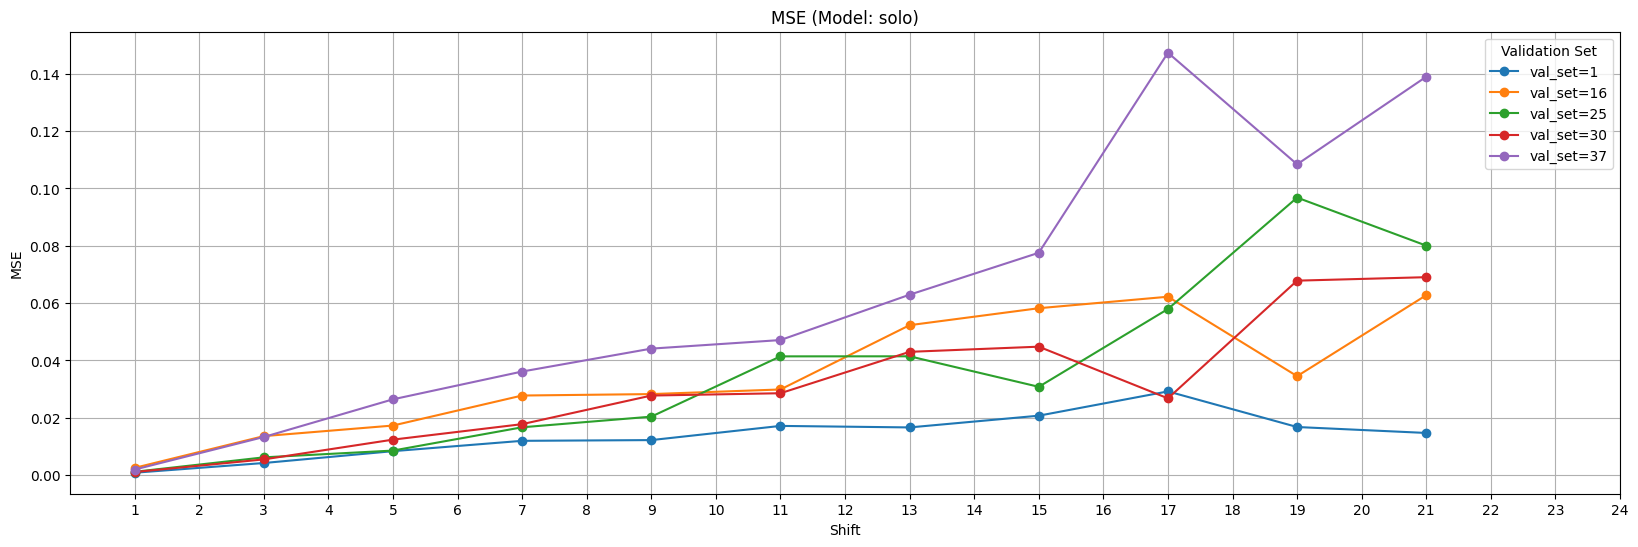

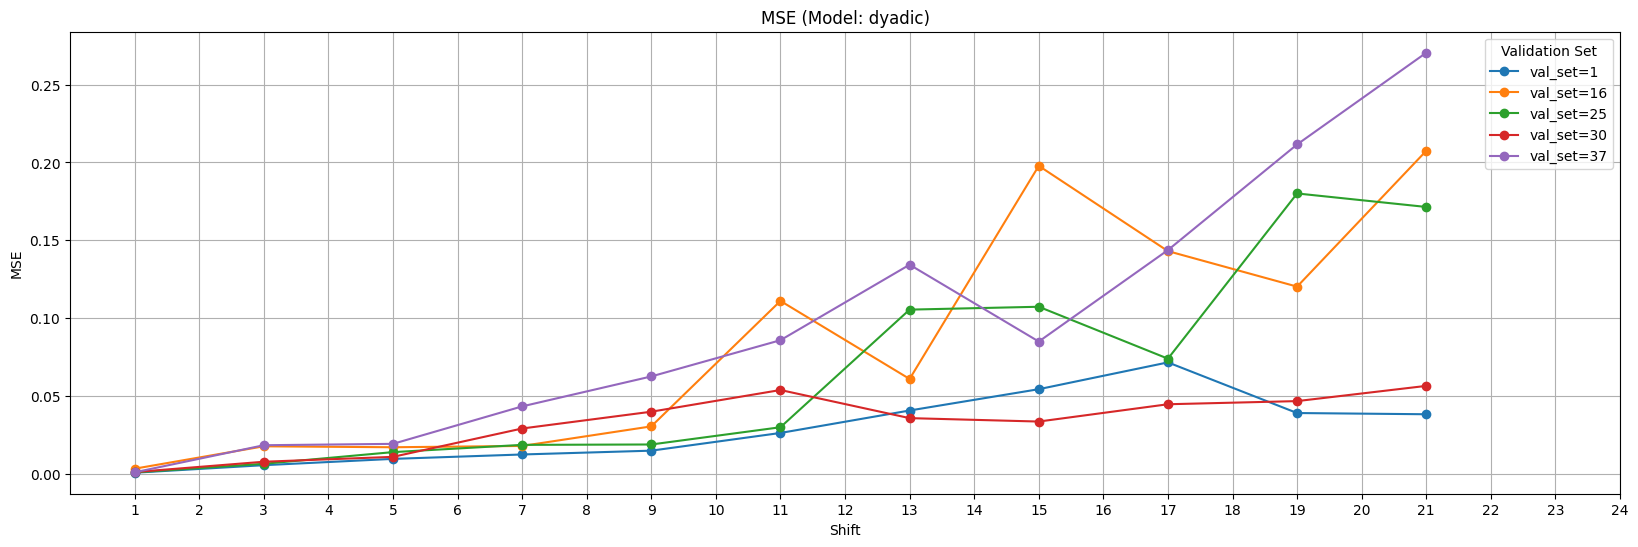

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results from the CSV file
df = pd.read_csv('C:/Users/kacpe/Desktop/lab_rotation_git/results/results_batch5_1var.csv')

# Define the specific x-axis ticks you want
x_ticks = np.arange(1, 25)

# Get unique values for val_set and model_type
val_sets = df["val"].unique()
models = df["model_type"].unique()

# Plot for each model
for model in models:
    plt.figure(figsize=(20, 6))
    
    # Subset dataframe for the current model
    model_df = df[df["model_type"] == model]
    
    # Plot each val_set on the same figure
    for val_set in val_sets:
        subset_df = model_df[model_df["val"] == val_set]
        
        # Plot MSE values for the current val_set with respect to "shift"
        plt.plot(subset_df["shift"], subset_df["mse"], marker='o', label=f"val_set={val_set}")

    # Labels, title, legend, and grid
    plt.xlabel("Shift")
    plt.ylabel("MSE")
    plt.title(f"MSE (Model: {model})")
    plt.legend(title="Validation Set")
    plt.grid(True)
    
    # Set specific x-axis ticks
    plt.xticks(x_ticks)
    
    # Display the plot
    plt.show()


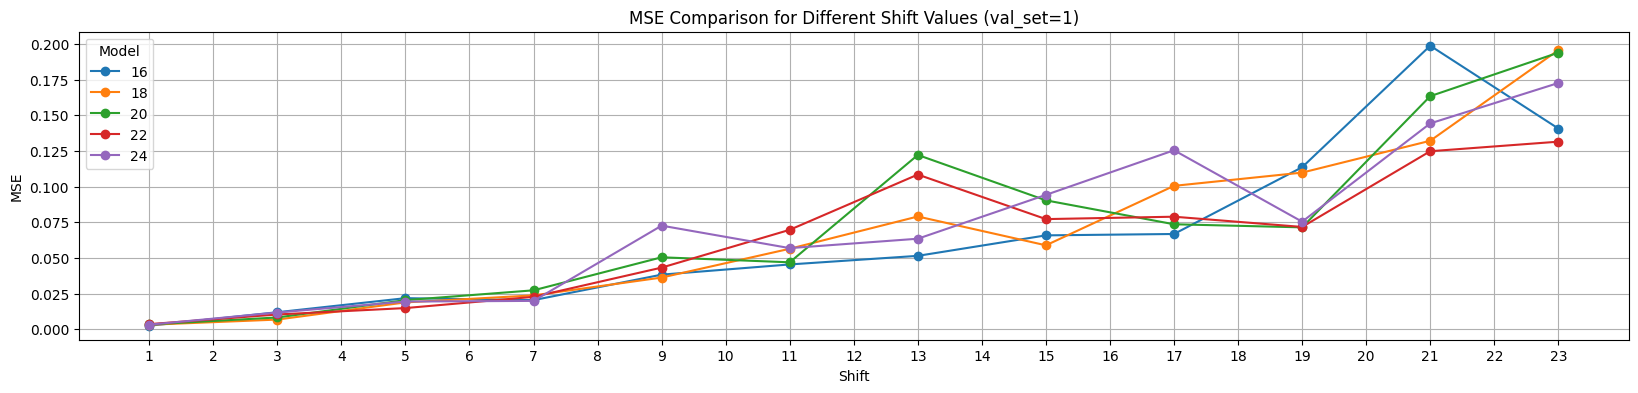

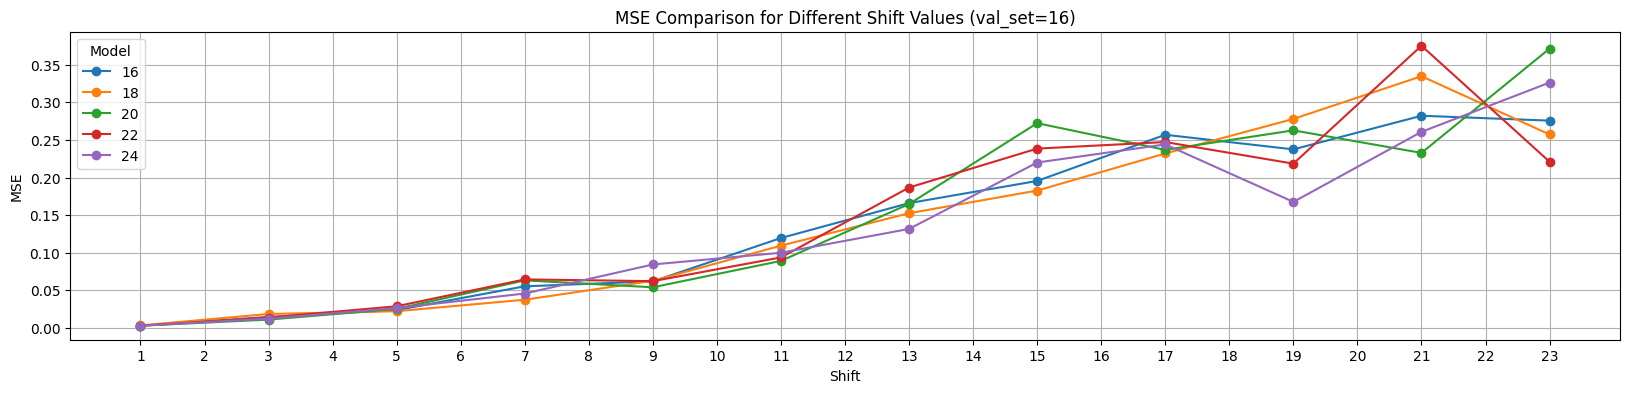

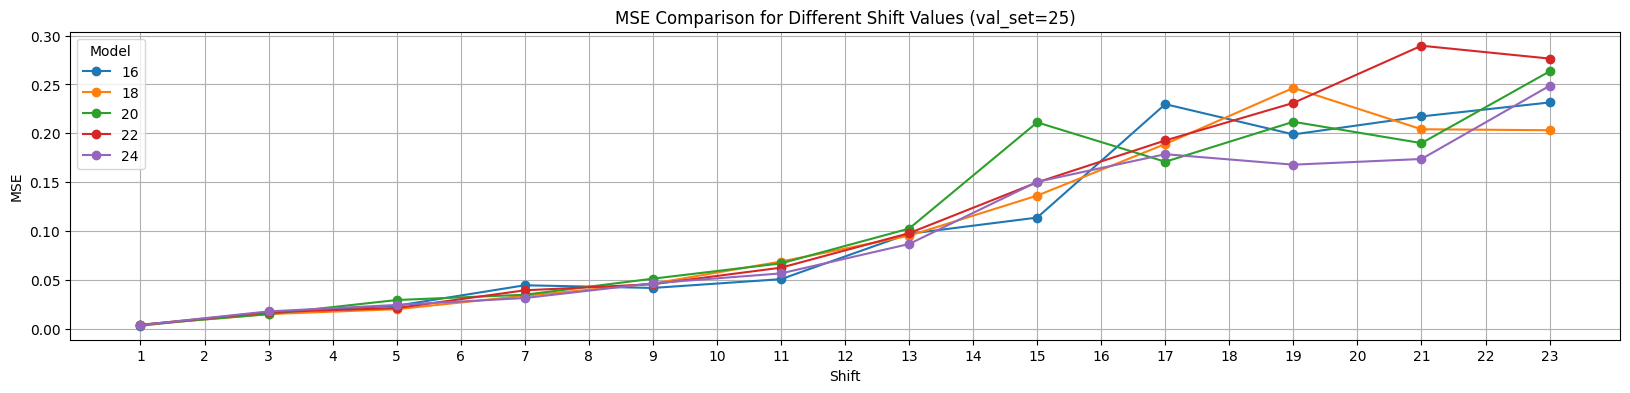

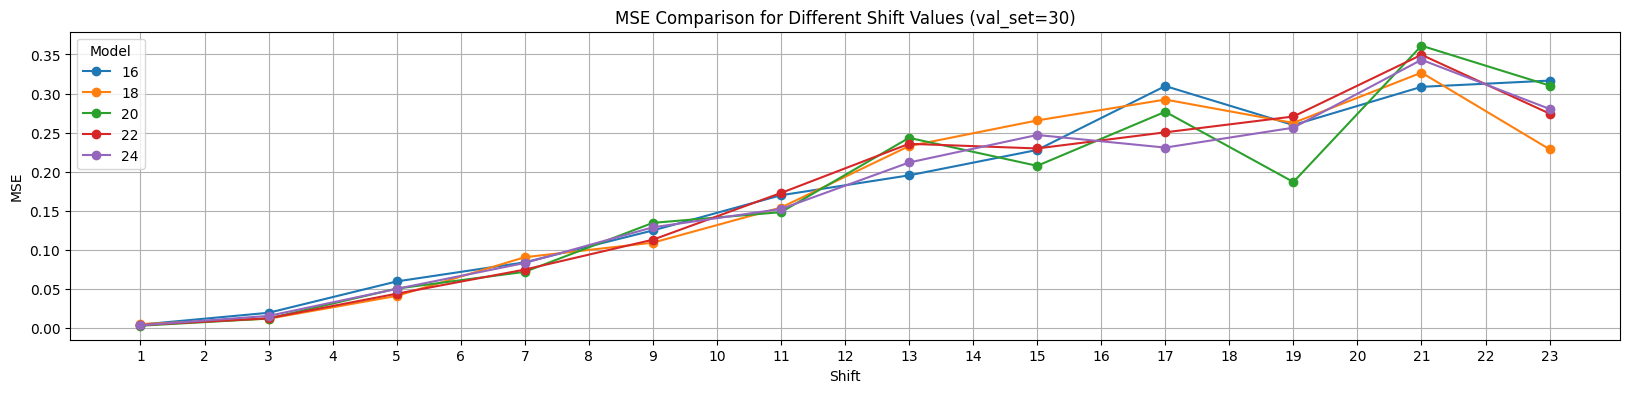

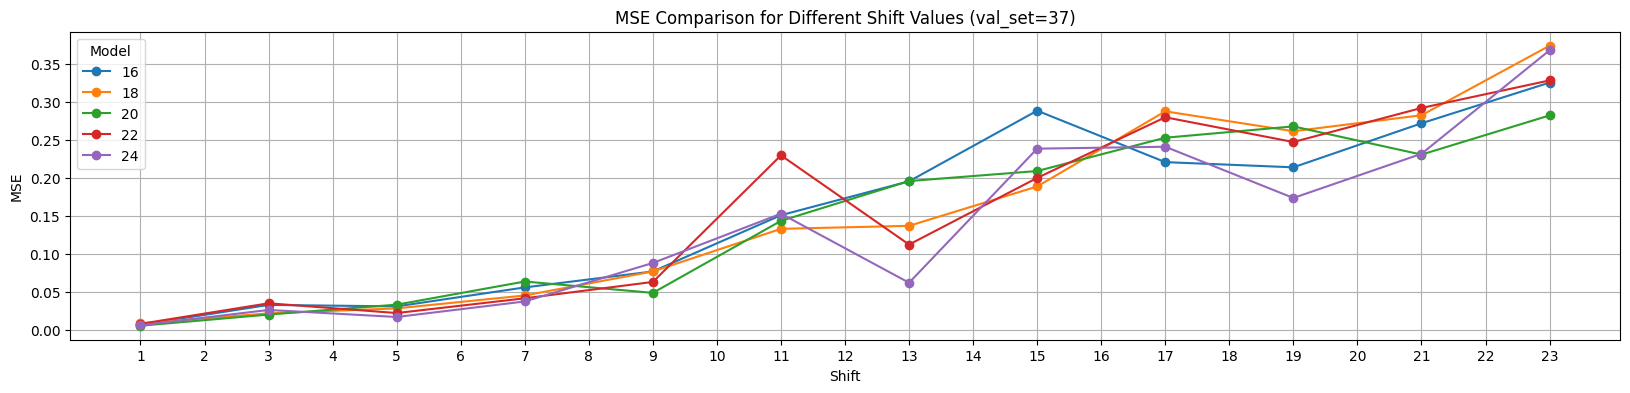

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results from the CSV file
df = pd.read_csv('C:/Users/kacpe/Desktop/lab_rotation_git/results/results_hidden_dyadic_4var.csv')

# Get unique val_set values
val_sets = df["val"].unique()
x_ticks = np.arange(1, 24)

# Plot for each val_set
for val_set in val_sets:
    subset_df = df[df["val"] == val_set]
    pivot_df = subset_df.pivot(index="shift", columns="hidden_size", values="mse")

    plt.figure(figsize=(20, 4))
    for model in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[model], marker='o', label=model)
        
    # Labels and title
    plt.xticks(x_ticks)
    plt.xlabel("Shift")
    plt.ylabel("MSE")
    plt.title(f"MSE Comparison for Different Shift Values (val_set={val_set})")
    plt.legend(title="Model")
    plt.grid(True)
    plt.show()


# PCA

In [ ]:
hidden_values = [20, 24]
epoch_values = [2000]
val_values = [1,16,25,30,37]
lag_values = [3,6,9,12,15]
from sklearn.decomposition import PCA
data = "C:/Users/kacpe/Desktop/lab_rotation_git/forKacper/datasets/combined_dataset.csv"
#val_values = [x for x in range(1, 62) if x not in [4,6,7,21,22,46,47,48,50,54,58]]

# Some Code

for h in hidden_values:
    for s in lag_values:
        for v in val_values:
            
            hidden_size_m = 16
            n_epochs = 2000  
            set_value = v
            shift = s
           # solo_h20_e2000_v[1, 16, 25, 30, 37]_s6_best_model.pth
           # solo_h20_e2000_v1_s3_best_model.pth
            model_name = 'solo'+'_h'+str(hidden_size_m)+'_e'+str(n_epochs)+'_v[1, 16, 25, 30, 37]'+'_s'+str(shift)
            labels = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            lag_word = '_lagged'
            input_size = 2
            output_size = len(labels)

            core = ExperimentEncoder(input_size,hidden_size_m, num_layers=1)
            readout = NonlinearDecoder(hidden_size_m, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            loss = nn.MSELoss()
            loss_fn = M2S_Loss3(loss)
            
            df = pd.read_csv(data)
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                                            # Function to bin within each trial


                # Apply binning within each 'trial' group
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            


            #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                    

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()
                


            # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

                                    # Define lagged monkey and human distance columns
            monkey_lagged_columns = [col + lag_word for col in columns_to_shift if col.startswith('a')]
        
                
            # Apply PCA to the shifted (lagged) columns for monkey and human distances with 2 components each
            pca_monkey = PCA(n_components=2)
        

            # Fit and transform the monkey and human lagged features
            monkey_pca_components = pca_monkey.fit_transform(shifted_df[monkey_lagged_columns])
       

            # Add each component as a separate column in the DataFrame
            shifted_df['monkey_pca_1'] = monkey_pca_components[:, 0]
            shifted_df['monkey_pca_2'] = monkey_pca_components[:, 1]
        

            # Drop only the original lagged columns (ending with '_lagged')
        
            shifted_df = shifted_df.drop(columns=monkey_lagged_columns)

            # Update features list to include the new PCA component columns
            
            features = ['monkey_pca_1', 'monkey_pca_2']





            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
            os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/0211_PCA/solo_PCA_h24')
            model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))
           # epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
           # yPred_val_m = yPred_val_m[0].squeeze(0).squeeze(-1).cpu().numpy()
                   # Loop through each batch in the validation dataloader
            with torch.no_grad():
                for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                    # Move inputs and outputs to the appropriate device
                    inputs = inputs.to(device)
                    outputs = [output.to(device) for output in outputs]  # Ensure all outputs are on the same device

                    # Get model predictions for the current batch
                    y_pred_batch = model(inputs)  # Predictions for the entire batch

                    # Iterate through each trial in the batch
                    for i in np.arange(len(y_pred_batch)):
                        prediction = y_pred_batch[i]  # Get the prediction for the current trial

                        # Convert the prediction and true values to numpy for plotting
                        prediction_np = prediction.detach().cpu().numpy()  # Convert to numpy for plotting
                        true_value_np = outputs[i].detach().cpu().numpy()  # True values for the current trial 
            
            


            
                    # Now that both y_pred and y_true are collected, calculate R²
                    mse_m = loss_fn(y_pred_batch,outputs)
                    r2_m = r2_score(true_value_np, prediction_np)
            hidden_size_h = 16
            model_name = 'dyadic'+'_h'+str(hidden_size_h)+'_e'+str(n_epochs)+'_v[1, 16, 25, 30, 37]'+'_s'+str(shift)
            labels = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4','oDistReach_1','oDistReach_2','oDistReach_3','oDistReach_4']
            lag_word = '_lagged'
            input_size = 4
            output_size = len(labels)
            
            core = ExperimentEncoder(input_size,hidden_size_h, num_layers=1)
            readout = NonlinearDecoder(hidden_size_h, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            
            df = pd.read_csv(data)
            
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                                            # Function to bin within each trial


                # Apply binning within each 'trial' group
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            


            #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                    

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()
                


            # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

                                    # Define lagged monkey and human distance columns
            monkey_lagged_columns = [col + lag_word for col in columns_to_shift if col.startswith('a')]
            human_lagged_columns = [col + lag_word for col in columns_to_shift if col.startswith('o')]
                
            # Apply PCA to the shifted (lagged) columns for monkey and human distances with 2 components each
            pca_monkey = PCA(n_components=2)
            pca_human = PCA(n_components=2)
            #print(df[monkey_lagged_columns])
            # Fit and transform the monkey and human lagged features
            monkey_pca_components = pca_monkey.fit_transform(shifted_df[monkey_lagged_columns])
            human_pca_components = pca_human.fit_transform(shifted_df[human_lagged_columns])

            # Add each component as a separate column in the DataFrame
            shifted_df['monkey_pca_1'] = monkey_pca_components[:, 0]
            shifted_df['monkey_pca_2'] = monkey_pca_components[:, 1]
            shifted_df['human_pca_1'] = human_pca_components[:, 0]
            shifted_df['human_pca_2'] = human_pca_components[:, 1]

            # Drop only the original lagged columns (ending with '_lagged')
            shifted_df = shifted_df.drop(columns=monkey_lagged_columns + human_lagged_columns)
            

            # Update features list to include the new PCA component columns
            features = ['monkey_pca_1', 'monkey_pca_2', 'human_pca_1', 'human_pca_2']
            
            




            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
            os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/0211_PCA/dyadic_PCA_h24')
            model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))
           # epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
           # yPred_val_m = yPred_val_m[0].squeeze(0).squeeze(-1).cpu().numpy()
                   # Loop through each batch in the validation dataloader
            with torch.no_grad():
                for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                    # Move inputs and outputs to the appropriate device
                    inputs = inputs.to(device)
                    outputs = [output.to(device) for output in outputs]  # Ensure all outputs are on the same device

                    # Get model predictions for the current batch
                    y_pred_batch = model(inputs)  # Predictions for the entire batch

                    # Iterate through each trial in the batch
                    for i in np.arange(len(y_pred_batch)):
                        prediction = y_pred_batch[i]  # Get the prediction for the current trial

                        # Convert the prediction and true values to numpy for plotting
                        prediction_np = prediction.detach().cpu().numpy()  # Convert to numpy for plotting
                        true_value_np = outputs[i].detach().cpu().numpy()  # True values for the current trial
                        
                        # Now that both y_pred and y_true are collected, calculate R²
            r2_h = r2_score(true_value_np, prediction_np)
            mse_h = loss_fn(y_pred_batch,outputs)
            
            print(f'solo_R2_{shift}_{set_value}_{hidden_size_m}_{r2_m}')
            print(f'dyadic_R2_{shift}_{set_value}_{hidden_size_h}_{r2_h}')
            print(f'solo_MSE_{shift}_{set_value}_{hidden_size_m}_{mse_m}')
            print(f'dyadic_MSE_{shift}_{set_value}_{hidden_size_h}_{mse_h}')
            

FileNotFoundError: [Errno 2] No such file or directory: 'solo_h16_e2000_v[1, 16, 25, 30, 37]_s3_best_model.pth'